# Day 7: Week 7.1 Review - Tree Ensembles Interview Prep

## 🎯 Learning Objectives
- Consolidate all tree ensemble methods
- Build comprehensive comparison pipeline
- Practice interview questions
- Final trading strategy showdown

---

## 📚 Week Summary

| Day | Topic | Key Concept |
|-----|-------|-------------|
| 1 | Decision Trees | Splitting, interpretability, overfitting |
| 2 | Random Forest | Bagging, OOB error, feature importance |
| 3 | XGBoost | Gradient boosting, regularization |
| 4 | LightGBM | Leaf-wise growth, speed, categoricals |
| 5 | CatBoost | Ordered boosting, categorical handling |
| 6 | Stacking | Meta-learning, out-of-fold predictions |

---

In [22]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from xgboost import XGBClassifier
# Note: CatBoost requires: pip install catboost
try:
    from catboost import CatBoostClassifier
    HAS_CATBOOST = True
except ImportError:
    HAS_CATBOOST = False
    print("⚠️ CatBoost not installed. Run: pip install catboost")
from sklearn.model_selection import TimeSeriesSplit, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import seaborn as sns
import time

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)

# Handle multi-level columns from yfinance
if isinstance(data.columns, pd.MultiIndex):
    prices = data['Close'][ticker]
    volume = data['Volume'][ticker]
else:
    prices = data['Close']
    volume = data['Volume']
    
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

⚠️ CatBoost not installed. Run: pip install catboost
📥 Downloading data...
✅ Data: 1254 days


In [23]:
# Comprehensive Feature Engineering
df = pd.DataFrame(index=prices.index)
df['price'] = prices
df['return'] = returns

# Momentum features
for lag in [1, 5, 10, 20, 60]:
    df[f'momentum_{lag}'] = prices.pct_change(lag)

# Volatility
for window in [5, 10, 20]:
    df[f'volatility_{window}'] = returns.rolling(window).std()

# Volume
df['volume_ratio'] = volume / volume.rolling(20).mean()

# MA Ratios
df['ma_5_20'] = prices.rolling(5).mean() / prices.rolling(20).mean() - 1
df['ma_20_50'] = prices.rolling(20).mean() / prices.rolling(50).mean() - 1

# RSI
delta = prices.diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
df['rsi'] = 100 - (100 / (1 + gain / loss))

# MACD
ema_12 = prices.ewm(span=12).mean()
ema_26 = prices.ewm(span=26).mean()
df['macd'] = (ema_12 - ema_26) / prices

# Target
df['next_return'] = returns.shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

df = df.dropna()
print(f"📊 Features: {len([c for c in df.columns if c not in ['price', 'return', 'next_return', 'target']])}, Samples: {len(df)}")

📊 Features: 13, Samples: 1193


In [24]:
# Prepare data with 3-way split
feature_cols = [c for c in df.columns if c not in ['price', 'return', 'next_return', 'target']]
X = df[feature_cols]
y = df['target']

# 70% train, 15% val, 15% test
train_idx = int(len(df) * 0.7)
val_idx = int(len(df) * 0.85)

X_train = X.iloc[:train_idx]
X_val = X.iloc[train_idx:val_idx]
X_test = X.iloc[val_idx:]

y_train = y.iloc[:train_idx]
y_val = y.iloc[train_idx:val_idx]
y_test = y.iloc[val_idx:]

returns_test = df['next_return'].iloc[val_idx:]

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 835, Val: 179, Test: 179


In [25]:
# Define all tree ensemble models
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, verbosity=-1),
}

# Add CatBoost only if installed
if HAS_CATBOOST:
    models['CatBoost'] = CatBoostClassifier(iterations=200, depth=5, learning_rate=0.1, random_seed=42, verbose=False)

# Train and evaluate all models
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

results = []
predictions = {}
probabilities = {}

for name, model in models.items():
    # Train
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    predictions[name] = y_pred
    probabilities[name] = y_proba
    
    # Validation performance (for model selection)
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    results.append({
        'Model': name,
        'Train Time': f'{train_time:.2f}s',
        'Val Acc': accuracy_score(y_val, y_val_pred),
        'Val F1': f1_score(y_val, y_val_pred),
        'Test Acc': accuracy_score(y_test, y_pred),
        'Test F1': f1_score(y_test, y_pred),
        'Test AUC': roc_auc_score(y_test, y_proba)
    })


COMPREHENSIVE MODEL COMPARISON


In [32]:
# Add Ensemble methods
# Simple Averaging
avg_proba = np.mean([probabilities[name] for name in probabilities], axis=0)
avg_pred = (avg_proba > 0.5).astype(int)
predictions['Ensemble (Avg)'] = avg_pred
probabilities['Ensemble (Avg)'] = avg_proba

# Stacking - Note: Using cv=5 instead of TimeSeriesSplit to avoid partition error
# For production trading, use manual stacking with TimeSeriesSplit (as shown in Day 6)
stacking = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=100, max_depth=5, random_state=42, eval_metric='logloss')),
        ('lgbm', lgb.LGBMClassifier(n_estimators=100, max_depth=5, random_state=42, verbosity=-1))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5  # KFold works with StackingClassifier; TimeSeriesSplit causes partition error
)

stacking.fit(X_train, y_train)
stack_pred = stacking.predict(X_test)
stack_proba = stacking.predict_proba(X_test)[:, 1]
predictions['Ensemble (Stack)'] = stack_pred
probabilities['Ensemble (Stack)'] = stack_proba

print("\n" + "="*70)
print("ENSEMBLE RESULTS")
print("="*70)
print(f"\n{'Method':<20} {'Accuracy':>12} {'F1':>12} {'AUC':>12}")
print("-" * 60)
print(f"{'Ensemble (Avg)':<20} {accuracy_score(y_test, avg_pred):>12.2%} {f1_score(y_test, avg_pred):>12.2%} {roc_auc_score(y_test, avg_proba):>12.4f}")
print(f"{'Ensemble (Stack)':<20} {accuracy_score(y_test, stack_pred):>12.2%} {f1_score(y_test, stack_pred):>12.2%} {roc_auc_score(y_test, stack_proba):>12.4f}")


ENSEMBLE RESULTS

Method                   Accuracy           F1          AUC
------------------------------------------------------------
Ensemble (Avg)             58.66%       62.24%       0.6013
Ensemble (Stack)           50.84%       65.62%       0.5056


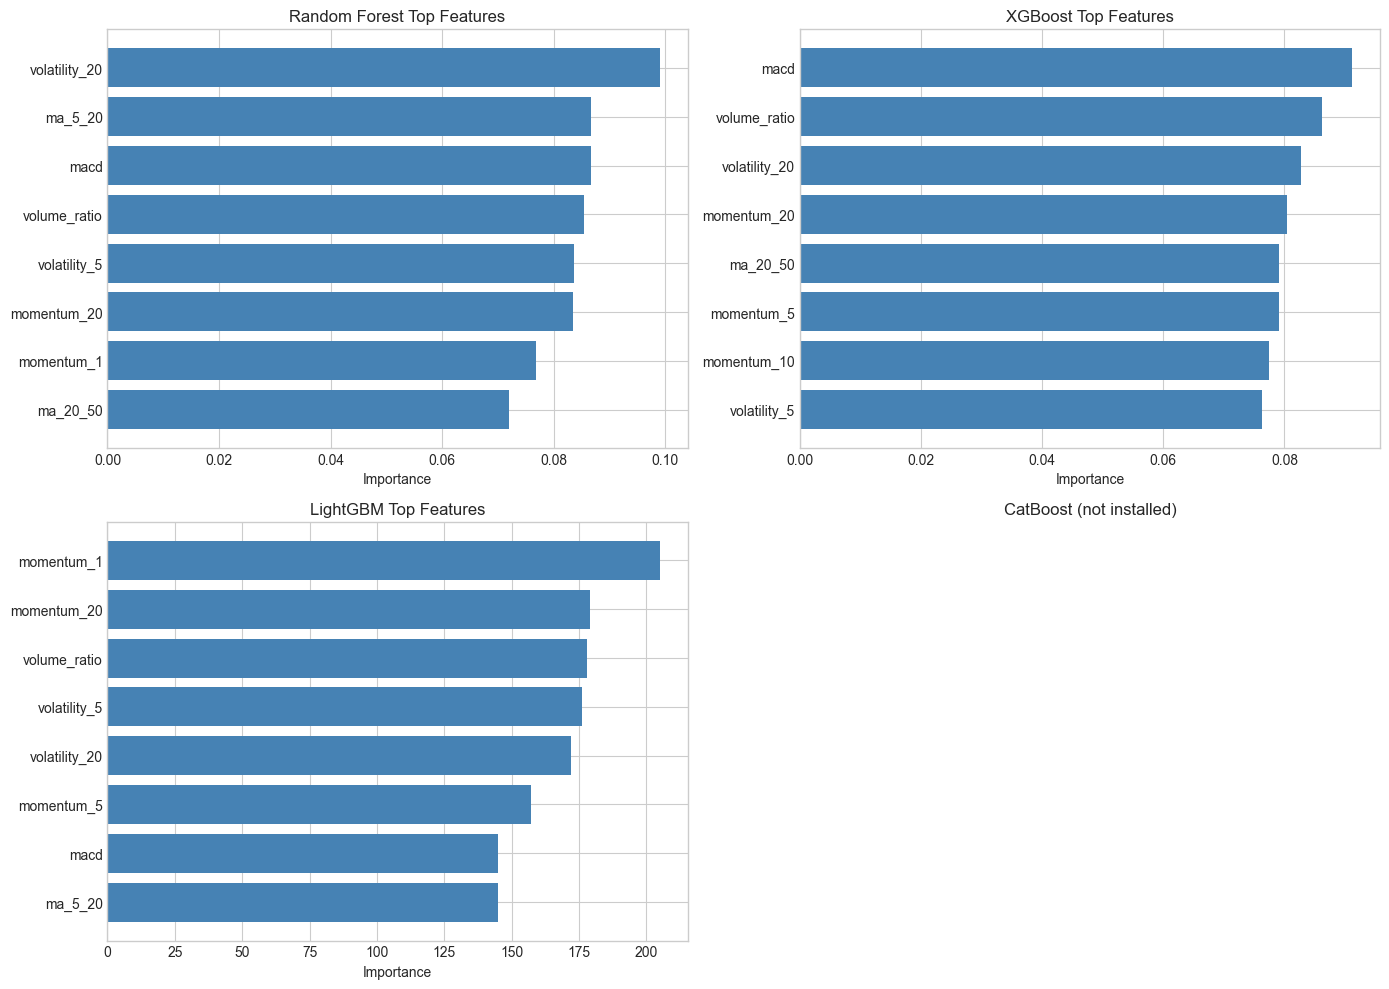

In [33]:
# Feature Importance Comparison
# Only include models that were actually trained
importance_models = ['Random Forest', 'XGBoost', 'LightGBM']
if HAS_CATBOOST:
    importance_models.append('CatBoost')

n_models = len(importance_models)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, name in enumerate(importance_models):
    model = models[name]
    importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=True).tail(8)
    
    axes[i].barh(importance['Feature'], importance['Importance'], color='steelblue')
    axes[i].set_xlabel('Importance')
    axes[i].set_title(f'{name} Top Features')

# Hide unused subplot if CatBoost not available
if not HAS_CATBOOST:
    axes[3].axis('off')
    axes[3].set_title('CatBoost (not installed)')

plt.tight_layout()
plt.show()

In [34]:
# Trading Strategy Backtest - All Models
backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values

for name in predictions.keys():
    safe_name = name.replace(' ', '_').replace('(', '').replace(')', '')
    backtest[f'{safe_name}_signal'] = predictions[name]
    backtest[f'{safe_name}_return'] = predictions[name] * backtest['actual_return']
    backtest[f'{safe_name}_cum'] = (1 + backtest[f'{safe_name}_return']).cumprod()

backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()

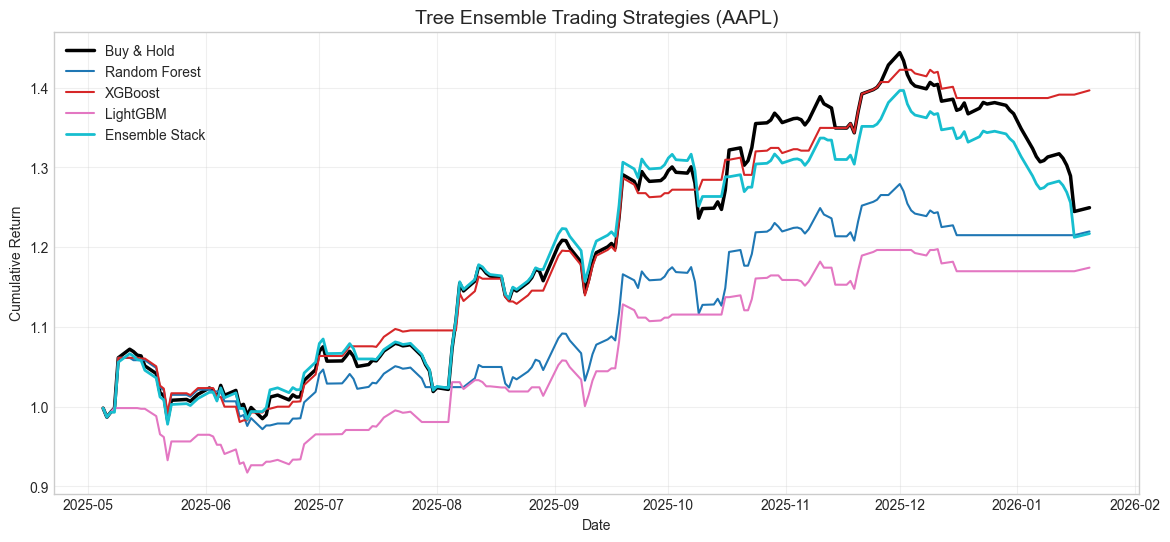

In [35]:
# Plot Top Models
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2.5, color='black')

top_models = ['Random_Forest', 'XGBoost', 'LightGBM', 'Ensemble_Stack']
if HAS_CATBOOST:
    top_models.insert(3, 'CatBoost')

colors = plt.cm.tab10(np.linspace(0, 1, len(top_models)))

for name, color in zip(top_models, colors):
    if f'{name}_cum' in backtest.columns:
        plt.plot(backtest.index, backtest[f'{name}_cum'], label=name.replace('_', ' '), 
                 linewidth=2 if 'Ensemble' in name else 1.5, color=color)

plt.title(f'Tree Ensemble Trading Strategies ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

In [36]:
# Comprehensive Performance Summary
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    trades = (returns != 0).sum()
    win_rate = (returns > 0).sum() / trades if trades > 0 else 0
    return total, sharpe, mdd, trades, win_rate

print("\n" + "="*80)
print("FINAL STRATEGY PERFORMANCE")
print("="*80)

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10} {'Trades':>8} {'Win Rate':>10}")
print("-" * 75)

# Buy and hold
total, sharpe, mdd, _, _ = calc_metrics(backtest['actual_return'], backtest['buy_hold_cum'])
print(f"{'Buy & Hold':<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%} {len(backtest):>8} {'N/A':>10}")

# All models
for name in predictions.keys():
    safe_name = name.replace(' ', '_').replace('(', '').replace(')', '')
    total, sharpe, mdd, trades, win_rate = calc_metrics(backtest[f'{safe_name}_return'], backtest[f'{safe_name}_cum'])
    print(f"{name:<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%} {trades:>8} {win_rate:>10.1%}")


FINAL STRATEGY PERFORMANCE

Strategy                Total Ret     Sharpe     Max DD   Trades   Win Rate
---------------------------------------------------------------------------
Buy & Hold                 24.94%       1.30    -13.80%      179        N/A
Decision Tree              23.26%       1.54     -9.16%      104      53.8%
Random Forest              21.96%       1.32     -8.43%      133      54.9%
XGBoost                    39.65%       2.57     -7.58%       95      62.1%
LightGBM                   17.42%       1.21     -8.10%       95      55.8%
Ensemble (Avg)             28.74%       1.91     -7.19%      103      59.2%
Ensemble (Stack)           21.70%       1.16    -13.18%      163      51.5%


In [37]:
# Next Day Predictions - All Models
latest = X.iloc[-1:]

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTIONS FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")

print(f"\n{'Model':<20} {'Prediction':>15} {'Confidence':>12}")
print("-" * 50)

bullish_count = 0
for name, model in models.items():
    pred = model.predict(latest)[0]
    proba = model.predict_proba(latest)[0, 1]
    direction = '📈 UP' if pred == 1 else '📉 DOWN'
    bullish_count += pred
    print(f"{name:<20} {direction:>15} {proba:>12.1%}")

# Ensemble
stack_pred = stacking.predict(latest)[0]
stack_proba = stacking.predict_proba(latest)[0, 1]
print(f"{'Ensemble (Stack)':<20} {'📈 UP' if stack_pred == 1 else '📉 DOWN':>15} {stack_proba:>12.1%}")

print(f"\n🎯 Consensus: {bullish_count}/{len(models)} base models bullish")


📊 NEXT DAY PREDICTIONS FOR AAPL

Date: 2026-01-20

Model                     Prediction   Confidence
--------------------------------------------------
Decision Tree                 📉 DOWN        44.9%
Random Forest                   📈 UP        53.1%
XGBoost                         📈 UP        85.1%
LightGBM                        📈 UP        72.2%
Ensemble (Stack)                📈 UP        51.5%

🎯 Consensus: 3/4 base models bullish


---

## 📝 Interview Questions & Answers

### Q1: Compare Decision Tree, Random Forest, XGBoost, LightGBM, CatBoost
**A:** 
- **Decision Tree**: Interpretable but high variance
- **Random Forest**: Bagging + feature sampling, reduces variance
- **XGBoost**: Gradient boosting + regularization, reduces bias
- **LightGBM**: Leaf-wise growth, faster, histogram binning
- **CatBoost**: Ordered boosting, native categorical support

### Q2: Why does Random Forest reduce variance?
**A:** By averaging multiple trees trained on bootstrap samples with random feature subsets, individual tree errors cancel out. The correlation between trees is reduced by feature subsampling.

### Q3: XGBoost regularization?
**A:** L1 (alpha) on leaf weights for sparsity, L2 (lambda) for smoothing, gamma for minimum loss reduction to split, and learning rate shrinkage.

### Q4: LightGBM vs XGBoost?
**A:** LightGBM uses leaf-wise growth (faster but can overfit), histogram binning (memory efficient), and native categorical support. XGBoost uses level-wise growth (more balanced trees).

### Q5: When to use stacking?
**A:** When you have diverse base models with similar performance. Use out-of-fold predictions to prevent leakage. Simple meta-models often work best.

---

## 🏢 Company Use Cases

| Company | Tree Ensemble Application |
|---------|-------------------------|
| Two Sigma | Alpha factor generation |
| Citadel | High-frequency signals |
| DE Shaw | Cross-asset prediction |
| WorldQuant | Alpha mining |
| AQR | Factor timing |

---

## 📅 Next Week: Instance-Based Methods (KNN, Kernel Methods)